In [1]:
import tifffile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import glob
import altair as alt

In [2]:
files = glob.glob("Rwanda/*.tif")

In [3]:
dates=[]
links=[]
for f in files:
    dates.append(pd.to_datetime(f.split('/')[1].split('.')[0]))
    links.append(f)

data=pd.DataFrame(list(zip(dates,links)),columns=['date','links'])    

In [4]:
data['key']=data.date.apply(lambda x: str(x.year)+'-'+str(x.month))
data['key_q']=data.date.apply(lambda x: str(x.year)+'-'+str(x.quarter))
data['key_y']=data.date.apply(lambda x: str(x.year))

In [5]:
data

,date,links,key,key_q,key_y
0,2014-01-01,Rwanda/20140101.tif,2014-1,2014-1,2014
1,2014-01-09,Rwanda/20140109.tif,2014-1,2014-1,2014
2,2014-01-17,Rwanda/20140117.tif,2014-1,2014-1,2014
3,2014-01-25,Rwanda/20140125.tif,2014-1,2014-1,2014
4,2014-02-02,Rwanda/20140202.tif,2014-2,2014-1,2014
...,...,...,...,...,...
271,2019-11-25,Rwanda/20191125.tif,2019-11,2019-4,2019
272,2019-12-03,Rwanda/20191203.tif,2019-12,2019-4,2019
273,2019-12-11,Rwanda/20191211.tif,2019-12,2019-4,2019
274,2019-12-19,Rwanda/20191219.tif,2019-12,2019-4,2019


In [31]:
def calcs(x,threshold):
    ndvi=np.nanmedian(x)
    x=np.where(x>=threshold,1,0)
    return x.sum(), np.round(100*np.sum(x)/(x.shape[0]*x.shape[1]),2),ndvi

def compute_stats(links):
    imgs=[]
    for i in links:
        imgs.append(tifffile.imread(i))
    imgs = np.asarray(imgs)
    med = np.nanmedian(imgs, axis=0)
    return calcs(med,0.5)

def fetch_results(keys,freq):
        key='key'
        if freq=='q':
            key='key_q'
        elif freq=='y':
            key='key_y'
            
        temp=[]
        for k in keys:
            x,y,z = compute_stats(data[data[key]==k].links.values)
            temp.append([pd.to_datetime(k, errors = 'coerce'),x,y,z])    
        return pd.DataFrame(temp, columns=['date','total','percent','ndvi'])    

In [32]:
results=fetch_results(data.key.unique(),'m')
results_q=fetch_results(data.key_q.unique(),'q')
results_y=fetch_results(data.key_y.unique(),'y')

/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning:

All-NaN slice encountered

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning:

invalid value encountered in greater_equal



In [8]:
results_q.sort_values(by='ndvi',ascending=False).head(10)

,date,total,percent,ndvi
9,2016-02-01,12853,28.05,0.419591
21,2019-02-01,13774,30.06,0.395304
3,2014-04-01,6447,14.07,0.384752
6,2015-03-01,4429,9.66,0.384053
12,2017-01-01,8711,19.01,0.375008
17,2018-02-01,9686,21.14,0.366984
8,2016-01-01,6936,15.13,0.366819
20,2019-01-01,7246,15.81,0.360187
11,2016-04-01,7661,16.72,0.342748
18,2018-03-01,3459,7.55,0.339804


In [34]:
results_q.set_index('date', inplace=True)
results.set_index('date', inplace=True)

In [10]:
results.diff(24).groupby([(results.index.year),(results.index.month)]).mean().dropna()

total  percent      ndvi
date date                            
2016 1     -2085.0    -4.55 -0.040021
     2     11944.0    26.06  0.153702
     6      8877.0    19.37  0.155411
     7      -315.0    -0.68  0.009718
     8      2231.0     4.87  0.204308
     9      -490.0    -1.07 -0.157717
     12     2792.0     6.09  0.003050
2017 1      6621.0    14.45  0.019720
     2      1065.0     2.33  0.002693
     3      6634.0    14.48  0.152087
     5    -11592.0   -25.29 -0.047945
     6     10049.0    21.93  0.181208
     7     -3357.0    -7.32 -0.149810
     8     -1738.0    -3.79 -0.159413
     9     -6211.0   -13.55 -0.109920
2018 1      -763.0    -1.66 -0.019737
     2    -10710.0   -23.37 -0.166129
     6      1652.0     3.61 -0.017110
     7      4028.0     8.79 -0.013212
     8      1554.0     3.39  0.005742
     9       752.0     1.64  0.111567
     12     3586.0     7.83  0.019650
2019 1      2495.0     5.44  0.066313
     2     -1503.0    -3.28 -0.063349
     4      9208.0    20.10  0.092654
     5      8018.0    17.50  0.027224
     6      5501.0    12.00  0.018896
     7       999.0     2.18  0.076327
     8      2146.0     4.68  0.171907
     9     -1743.0    -3.81 -0.099005
     12    13525.0    29.51  0.130048

In [28]:
results.diff(12).groupby([(results.index.year),(results.index.quarter)]).mean().dropna()

total    percent      ndvi
date date                                  
2015 1      -73.333333  -0.163333  0.022952
     2     3445.000000   7.516667  0.038335
     3     2553.333333   5.570000  0.110203
2016 1     4996.000000  10.903333  0.051237
     2     1837.666667   4.013333  0.174285
     3    -2078.000000  -4.530000 -0.091434
2017 1     -222.666667  -0.483333 -0.040031
     2    -2775.000000  -6.056667 -0.017045
     3    -1690.666667  -3.690000 -0.048280
     4    -2848.000000  -6.213333 -0.015200
2018 1    -4215.333333  -9.200000 -0.052902
     2     1948.666667   4.253333 -0.024032
     3     3802.000000   8.296667  0.082979
     4     6253.333333  13.643333  0.037970
2019 1     2325.666667   5.073333  0.054384
     2     5627.000000  12.280000  0.042929
     3    -3334.666667  -7.280000 -0.033237
     4    -1073.333333  -2.340000  0.095198

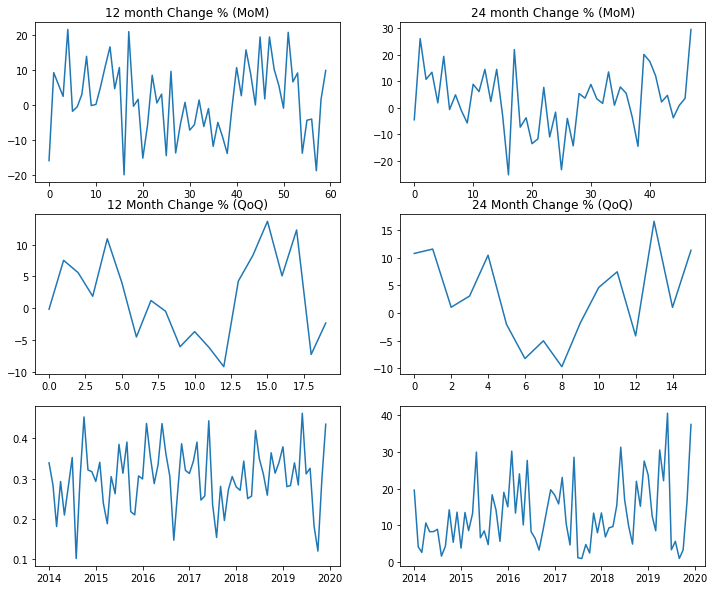

In [35]:
fig, ax=plt.subplots(3,2, figsize=(12,10))
ax[0][1].plot(results.diff(24).groupby([(results.index.year),(results.index.month)]).mean().dropna()['percent'].values)
ax[0][1].set_title("24 month Change % (MoM)");

ax[0][0].plot(results.diff(12).groupby([(results.index.year),(results.index.month)]).mean().dropna()['percent'].values)
ax[0][0].set_title("12 month Change % (MoM)");

ax[1][0].plot(results.diff(12).groupby([(results.index.year),(results.index.quarter)]).mean().dropna()['percent'].values)
ax[1][0].set_title('12 Month Change % (QoQ)');

#ax[1][1].plot(results_y.percent.diff(1))
ax[1][1].plot(results.diff(24).groupby([(results.index.year),(results.index.quarter)]).mean().dropna()['percent'].values)
ax[1][1].set_title('24 Month Change % (QoQ)');

ax[2][0].plot(results.ndvi)
ax[2][1].plot(results.percent);

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error


In [ ]:
plot_pacf(results['total'], lags=14)

In [ ]:
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

In [ ]:
for d in range(1, 14):
    
    # Print out a counter and the corresponding p-value.
    print(f'Checking difference of {d}.')
    print(f'p-value = {interpret_dftest(adfuller(results.total.diff(d).dropna()))["p-value"]}.')
          
    # If our data, differenced by d time periods, are stationary, print that out!
    if interpret_dftest(adfuller(results.total.diff(d).dropna()))['p-value'] < 0.05:
        print(f'Differencing our time series by d={d} yields a stationary time series!')
    
    print()

In [ ]:
model = ARIMA(endog = results.total.diff(2).dropna(), # endog = Y variable
              order = (2,0,2))
arima_1_4_0 = model.fit()
preds = arima_1_4_0.predict()



In [ ]:
mean_squared_error(results.total.diff(2).dropna(), preds)

In [ ]:

arima_1_4_0.forecast(6)

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(results_q.total.diff(6).dropna(), color = 'blue')
plt.plot(preds, color = 'orange')
#plt.title(label = 'Bus Ridership with ARIMA(1,4,0) Predictions', fontsize=18)
plt.show();

In [13]:
from fbprophet import Prophet

In [14]:
x=list(results.diff(12).groupby([results.index.year,results.index.quarter])['percent'].mean().dropna().values)

In [48]:
x=list(results.percent.values)

In [49]:
d=list(pd.date_range(start='2014-01-01', end='2019-12-31', freq='M'))

In [38]:
temp=pd.DataFrame(list(zip(d,x)), columns = ['ds', 'y'])
#temp=results_q.reset_index()[['date','ndvi']]
#len(d)

In [50]:
#temp=x.loc[:,['d','percent']]
temp.columns = ['ds', 'y']

In [51]:
temp.head()

,ds,y
0,2014-01-31,0.338940
1,2014-02-28,0.283176
2,2014-03-31,0.180717
3,2014-04-30,0.292605
4,2014-05-31,0.209219


In [59]:
m = Prophet(daily_seasonality=False, yearly_seasonality=True
            ,seasonality_mode='additive',seasonality_prior_scale=20)
#m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m.add_seasonality(name='quarterly', period=365.25/4, fourier_order=7)
m.fit(temp)#, control={'max_treedepth': 20})

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


In [60]:
future = m.make_future_dataframe(periods=12, freq='M')
future.tail()

,ds
79,2020-08-31
80,2020-09-30
81,2020-10-31
82,2020-11-30
83,2020-12-31


In [61]:
forecast = m.predict(future)

In [ ]:
forecast['y']=temp.y

In [ ]:
forecast.head()

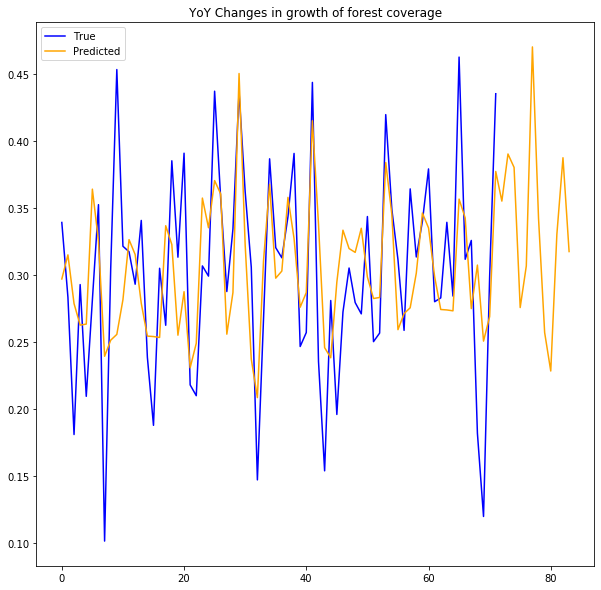

In [62]:
plt.figure(figsize=(10,10))
#plt.axis('off')

plt.plot(temp.y, color = 'blue', label='True')
plt.plot(forecast.yhat, color = 'orange' ,label='Predicted')
plt.title("YoY Changes in growth of forest coverage")

plt.legend();
#plt.imsave('static/images/sunder_res.png', img, cmap='Greys', dpi=500)

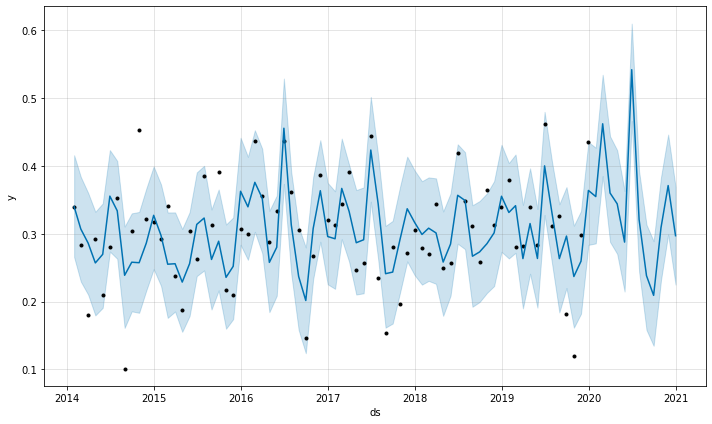

In [57]:
pd.plotting.register_matplotlib_converters()
# known issue in pandas right now
# github issue: https://github.com/facebook/prophet/issues/999

m.plot(forecast);

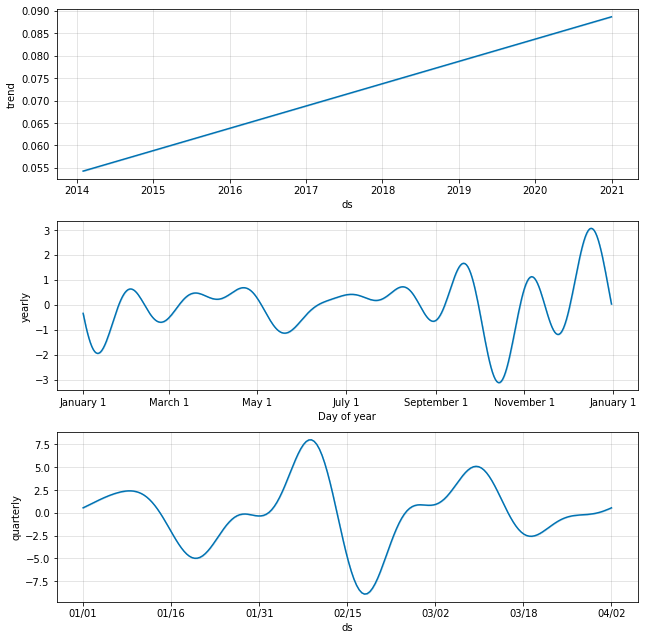

In [63]:
m.plot_components(forecast);

In [ ]:
t=results.diff(24).groupby([(results.index.year),(results.index.quarter)]).mean().dropna()['percent'].values

In [ ]:
results_q.reset_index(inplace=True)

In [ ]:
results_q

In [ ]:
alt.Chart(results_q.diff(24)).mark_line().encode(
    alt.X('date', axis=alt.Axis(title="")),
    alt.Y('percent', axis=alt.Axis(title="Normalized difference vegetation index")),
    tooltip=['percent','date'],
).properties(width=400,height=400).interactive()#.save('chartName.html')

In [ ]:
def get_mask(links):
    imgs=[]
    for i in links:
        imgs.append(tifffile.imread(i))
    imgs = np.asarray(imgs)
    med = np.nanmedian(imgs, axis=0)
    return med

In [ ]:
import matplotlib
for year in data.key_y.unique():
    img=get_mask(data[data['key_y']==year].links.values)
    matplotlib.image.imsave('static/images/Sunder_mask_{}.png'.format(year), img, cmap='Greys', dpi=500)

In [ ]:
plt.imshow(img, cmap='Greys')